## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation


sns.set()
sns.set_style("white")
sns.set_style("ticks")

## AUTOMI vs Time Lag

In [3]:
# load AUTOMI vs Time Lag
modes = ['normal', 'amphetamine', 'caffeine']
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
cnt = 0

for mode in modes:
    print(mode)
    trajs = os.listdir(root_dir + mode + '/' )
    for traj_n in trajs:
        if traj_n != '.ipynb_checkpoints': 
            print(traj_n)
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'sub_sampling_analysis/'
            autoMI = np.load(path + 'na_auto_MI_per_lag_6.npy')
            autoMI = np.reshape(autoMI, (1, np.max(autoMI.shape)))
            
            # append trajectory to all trajectories
            if cnt==0:
                rats_autoMI = autoMI
            if cnt>0:
                rats_autoMI = np.concatenate((rats_autoMI, autoMI), axis=0)
            
            cnt += 1
            

normal
traj_5
traj_3
traj_2
traj_1
amphetamine
traj_5
traj_3
traj_7
traj_1
caffeine
traj_8
traj_4
traj_2
traj_6


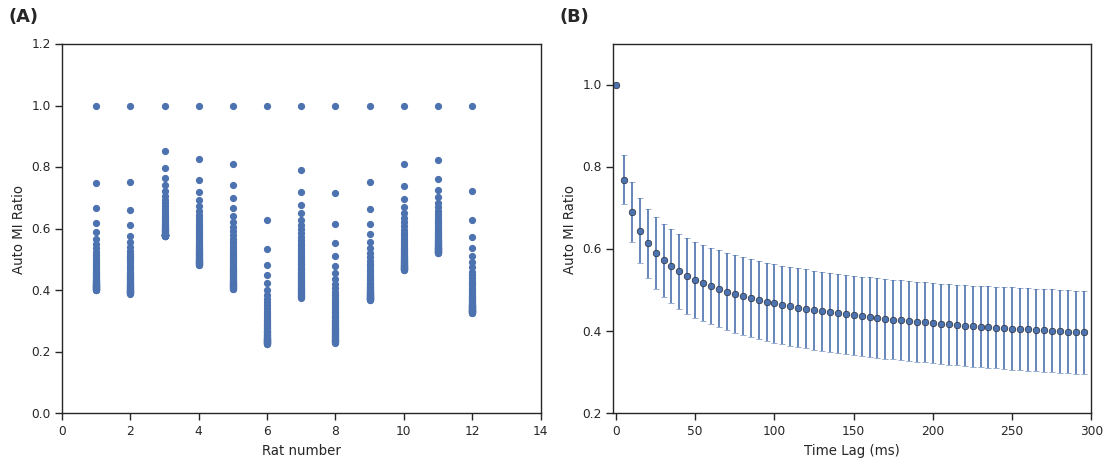

In [4]:
# normalize each AUTOMI vs Time Lag independently
for i in range(rats_autoMI.shape[0]):
    rats_autoMI[i, :] = rats_autoMI[i, :]/(np.max(rats_autoMI[i, :]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
labels = ['(A)', '(B)']
for lag_idx in range(rats_autoMI.shape[1]):
    ax1.scatter(np.arange(1,rats_autoMI.shape[0]+1), rats_autoMI[:, lag_idx], color='b', s=30, alpha=1)
    ax1.set_ylabel('Auto MI Ratio')
    ax1.set_xlabel('Rat number')
    plt.xlim([0, rats_autoMI.shape[0]+1])
    
ax1.text(-0.05, 1.1, labels[0], transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')  
    
mean_autoMI = np.mean(rats_autoMI, axis=0)
var_autoMI = np.var(rats_autoMI, axis=0)
# plt.figure()    
ax2.scatter(5*np.arange(rats_autoMI.shape[1]), mean_autoMI)
ax2.errorbar(5*np.arange(rats_autoMI.shape[1]), mean_autoMI, np.sqrt(var_autoMI), fmt="o", color="b")
ax2.set_ylabel('Auto MI Ratio')
ax2.set_xlabel('Time Lag (ms)')
ax2.set_xlim([-2, 5*rats_autoMI.shape[1]])

ax2.text(-0.05, 1.1, labels[1], transform=ax2.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

fig.tight_layout()
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/'
name_out = 'subsampling_analysis'
fig.savefig(path_out +  name_out  + ".eps")


finished
finished
finished
finished
finished
finished
finished
finished


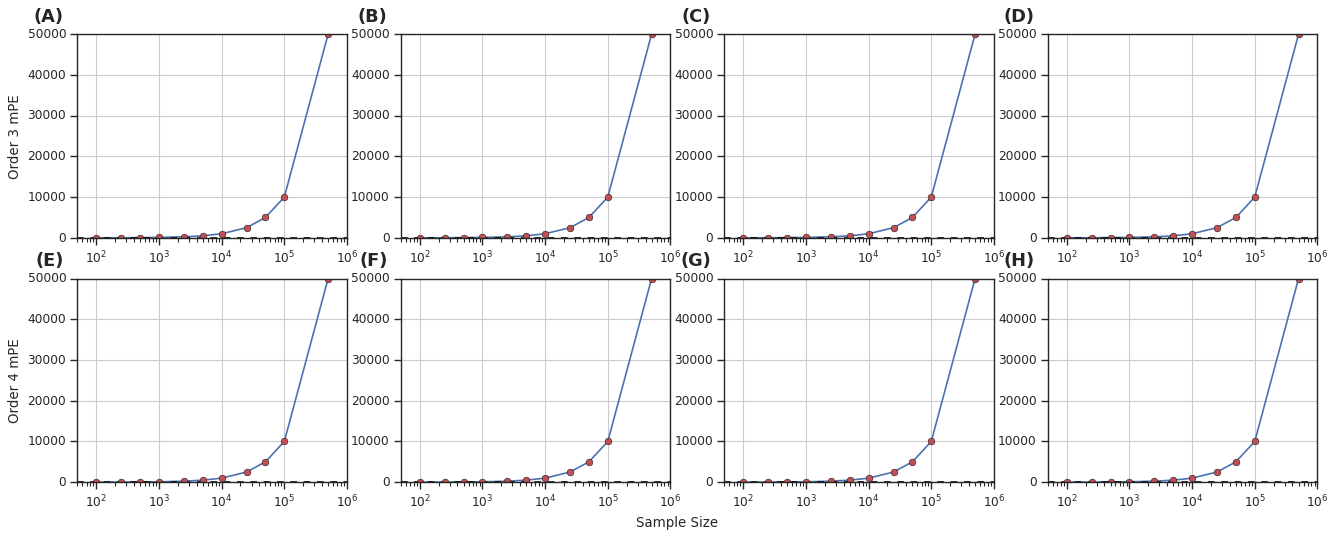

In [10]:
# params
orders = [3, 4]
n_PCs = [2, 3, 4, 6]
bound_len = 5e06
n_trials = 20
length_ = 10

cnt = 0
fig, axs = plt.subplots(len(orders), len(n_PCs), figsize=(20, 7))

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)']

sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 500000]

# to_save = np.zeros((n_trials, len(sizes), 4))

# convergence analysis over 20 trials
for i, order in enumerate(orders):
    
    for j, n_PC in enumerate(n_PCs):
        
        if n_PC >=4:
            sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 500000]
        else:
            sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 500000]
        
        H_bound = np.log2(mt.factorial(order)**n_PC)
    
        ''' # create fundamental unit for synthetic data
        f_unit = np.random.rand(n_PC, length_)

        # calculating entropy bound using the entire trajectory length
        rand_traj = np.zeros((n_PC, int(bound_len)))

        for ii in range(int(bound_len/length_)):

            # create trajectory for entropy bound
            idx = ii * length_
            rand_traj[:, idx:idx+length_] = f_unit

            # update fundamental unit 
            f_unit = np.random.rand(n_PC, length_)

        #######################################################################
        print("CALCULATING ENTROPY BOUND")
        [H_bound, _] = mPE_(rand_traj, order)
        print("finished")
        #######################################################################'''

        # initialize sample entropy array
        sample_H = np.zeros((n_trials, len(sizes)))

        for trial in range(n_trials):
            f_unit = np.random.rand(n_PC, length_)

            for jj, size in enumerate(sizes):
                sample_traj = np.zeros((n_PC, size))

                for iii in range(int(size/length_)):

                    # create trajectory for entropy bound
                    idx = iii * length_
                    sample_traj[:, idx:idx+length_] = f_unit

                    # update fundamental unit 
                    f_unit = np.random.rand(n_PC, length_)

                #######################################################################
                # print("CALCULATING SAMPLE ENTROPY")
                [H_sample, _] = iii, 0
                sample_H[trial, jj] = H_sample
                #######################################################################

        
        axs[i, j].plot(sizes, np.mean(sample_H, axis=0))
        axs[i, j].errorbar(sizes, np.mean(sample_H, axis=0), yerr=np.var(sample_H, axis=0), fmt="o", color="r")
        axs[i, j].axhline(y=H_bound, color="black", linestyle="--")
        if j == 0:
            axs[i, j].set_ylabel('Order ' + str(order) + ' mPE')
        else:
            axs[i, j].set_ylabel('')

        axs[i, j].set_xscale("log")
        axs[i, j].set_xlim([50, 1e06])
        
        x_min, x_max, y_min, y_max = axs[i, j].axis()
        if y_max - y_min < 0.3:
            axs[i][j].set_ylim([H_bound - 0.3,  + H_bound + 0.1])
    
        axs[i, j].grid()
        axs[i, j].text(-0.05, 1.13, labels[cnt], transform=axs[i, j].transAxes, fontsize=16, fontweight='bold', va='top', ha='right') 
        
        # to_save[:, :, cnt] = sample_H
        
        cnt += 1
        
        print('finished')

fig.text(0.5, 0.02, 'Sample Size', ha='center')
fig.show()
name_out = 'bias_reduction_2'
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/'
# plt.savefig(path_out +  name_out  + ".png")